In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Set GPU as the default device
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Verify that GPU is the default device
print("Default Device: ", tf.test.gpu_device_name())

Default Device:  /device:GPU:0


In [ ]:
!unzip drive/MyDrive/project2.zip

Archive:  drive/MyDrive/project2.zip
replace project2/corridor_both_directions_revised.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: project2/corridor_both_directions_revised.txt  
  inflating: project2/corridor_both_directions_revised_dataset.txt  
  inflating: project2/data_preprocessing.py  
  inflating: project2/left_turn_revised.txt  
  inflating: project2/left_turn_revised_dataset.txt  
  inflating: project2/supermarket_revised.txt  
  inflating: project2/supermarket_revised_dataset.txt  


In [ ]:
from creating_preprocessing_data import *

In [ ]:
!unzip drive/MyDrive/Pedestrian_Trajectories.zip

Archive:  drive/MyDrive/Pedestrian_Trajectories.zip
 extracting: Bottleneck_Data.zip     
 extracting: Corridor_Data.zip       


In [ ]:
!unzip ./Corridor_Data.zip

Archive:  ./Corridor_Data.zip
  inflating: ug-180-015.txt          
  inflating: ug-180-030.txt          
  inflating: ug-180-060.txt          
  inflating: ug-180-085.txt          
  inflating: ug-180-095.txt          
  inflating: ug-180-110.txt          
  inflating: ug-180-140.txt          
  inflating: ug-180-230.txt          


In [ ]:
corridor_data = create_dataset('ug-180-015.txt')


      timestep  ID         X         Y
0            0   1  0.402700  4.934930
8643         0  52  1.345620 -0.043027
8822         0  53  0.733364 -0.027846
1            1   1  0.403320  4.935130
8644         1  52  1.345520 -0.044624
...        ...  ..       ...       ...
8454      1641  50  1.742910 -5.895560
8303      1642  49  2.529760 -6.707190
8455      1642  50  1.770870 -5.980720
8456      1643  50  1.796320 -6.063130
8304      1643  49  2.583440 -6.767690

[9158 rows x 4 columns]


In [ ]:
corridor_data.lt(0).any().any()


True

In [ ]:
from preprocessing import *

In [ ]:
from scipy.spatial import distance 

In [ ]:
def remove_diagonal(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

In [ ]:
NO_NEIGHBORS = 5
TIMESTEP_LENGTH = 0.4

dic = {
    'timestep': [],
    'pid': [],
    'pos': [],
    'mean_spacing': [],
    'speed': [],
    'knn': []
}

for timestep in range(1, corridor_data.timestep.max()):
    frame = corridor_data[corridor_data.timestep == timestep]
    next_frame = corridor_data[corridor_data.timestep == timestep + 1]

    frame = frame[frame['ID'].isin(next_frame['ID'])]
    next_frame = next_frame[next_frame['ID'].isin(frame['ID'])]

    if len(frame) <= NO_NEIGHBORS:
        continue

    pos = frame[['X', 'Y']].to_numpy()
    next_pos = next_frame[['X', 'Y']].to_numpy()

    dist = distance.squareform(distance.pdist(pos))
    dist = remove_diagonal(dist)[:, :NO_NEIGHBORS]

    knn = np.argsort(dist, axis=1)

    dic['timestep'] += frame.timestep.to_list()
    dic['pid'] += frame.ID.to_list()
    dic['pos'] += pos.tolist()
    dic['mean_spacing'] += dist.mean(axis = 1).tolist()
    dic['speed'] += (np.linalg.norm(next_pos - pos, axis=1) / TIMESTEP_LENGTH).tolist() 
    dic['knn'] += (pos[knn] - pos[:, np.newaxis]).tolist()



In [ ]:
corridor_temp = pd.DataFrame(dic)
# df2.to_csv('data/corridor_both_directions.csv', sep=' ', index=False)
corridor_temp

,timestep,pid,pos,mean_spacing,speed,knn
0,161,54,"[1.07707, 2.28013]",4.371662,16.998737,"[[-1.582811, 3.0538900000000004], [-1.197155, ..."
1,161,3,"[-0.505741, 5.334020000000001]",6.163001,8.754096,"[[0.0, 0.0], [1.582811, -3.0538900000000004], ..."
2,161,2,"[0.6540680000000001, 4.192769999999999]",5.140362,23.049976,"[[-1.159809, 1.1412500000000012], [0.423001999..."
3,161,53,"[-0.120085, -4.3632]",6.058331,10.716448,"[[1.1042130000000001, 4.217115], [0.0, 0.0], [..."
4,161,1,"[0.984128, -0.146085]",4.334770,14.103494,"[[0.09294199999999997, 2.426215], [-0.33005999..."
...,...,...,...,...,...,...
5546,1564,46,"[1.52569, -5.07759]",3.250625,0.194596,"[[0.0, 0.0], [-0.5905779999999999, 1.454059999..."
5547,1564,47,"[0.935112, -3.62353]",2.665059,0.222012,"[[0.5905779999999999, -1.4540599999999997], [-..."
5548,1564,45,"[2.48663, -6.858350000000001]",4.817399,15.533664,"[[-0.9609399999999999, 1.7807600000000008], [-..."
5549,1564,50,"[1.25463, 0.14442]",3.893060,17.954548,"[[0.0, 0.0], [-0.36525799999999986, -2.1883100..."


In [ ]:
corridor_processed = convert_df(corridor_temp)
corridor_processed

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
0,161,54,16.998737,4.371662,54,1.077070,2.280130,-1.582811,3.053890,-1.197155,-6.643330,0.000000,0.000000,-0.423002,1.912640,-0.092942,-2.426215
1,161,3,8.754096,6.163001,3,-0.505741,5.334020,0.000000,0.000000,1.582811,-3.053890,0.385656,-9.697220,1.159809,-1.141250,1.489869,-5.480105
2,161,2,23.049976,5.140362,2,0.654068,4.192770,-1.159809,1.141250,0.423002,-1.912640,-0.774153,-8.555970,0.000000,0.000000,0.330060,-4.338855
3,161,53,10.716448,6.058331,53,-0.120085,-4.363200,1.104213,4.217115,0.000000,0.000000,1.197155,6.643330,0.774153,8.555970,-0.385656,9.697220
4,161,1,14.103494,4.334770,1,0.984128,-0.146085,0.092942,2.426215,-0.330060,4.338855,-1.104213,-4.217115,0.000000,0.000000,-1.489869,5.480105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546,1564,46,0.194596,3.250625,46,1.525690,-5.077590,0.000000,0.000000,-0.590578,1.454060,-0.636318,3.033700,-0.271060,5.222010,0.960940,-1.780760
5547,1564,47,0.222012,2.665059,47,0.935112,-3.623530,0.590578,-1.454060,-0.045740,1.579640,0.319518,3.767950,0.000000,0.000000,1.551518,-3.234820
5548,1564,45,15.533664,4.817399,45,2.486630,-6.858350,-0.960940,1.780760,-1.551518,3.234820,-1.597258,4.814460,-1.232000,7.002770,0.000000,0.000000
5549,1564,50,17.954548,3.893060,50,1.254630,0.144420,0.000000,0.000000,-0.365258,-2.188310,-0.319518,-3.767950,0.271060,-5.222010,1.232000,-7.002770


In [ ]:
print(corridor_processed.shape)

(5551, 17)


In [ ]:
corridor_processed.head()

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
0,161,54,16.998737,4.371662,54,1.077070,2.280130,-1.582811,3.053890,-1.197155,-6.643330,0.000000,0.000000,-0.423002,1.91264,-0.092942,-2.426215
1,161,3,8.754096,6.163001,3,-0.505741,5.334020,0.000000,0.000000,1.582811,-3.053890,0.385656,-9.697220,1.159809,-1.14125,1.489869,-5.480105
2,161,2,23.049976,5.140362,2,0.654068,4.192770,-1.159809,1.141250,0.423002,-1.912640,-0.774153,-8.555970,0.000000,0.00000,0.330060,-4.338855
3,161,53,10.716448,6.058331,53,-0.120085,-4.363200,1.104213,4.217115,0.000000,0.000000,1.197155,6.643330,0.774153,8.55597,-0.385656,9.697220
4,161,1,14.103494,4.334770,1,0.984128,-0.146085,0.092942,2.426215,-0.330060,4.338855,-1.104213,-4.217115,0.000000,0.00000,-1.489869,5.480105


In [ ]:
corridor_processed.describe()

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
count,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000
mean,929.654297,28.028643,9.122506,4.313683,28.028643,0.772065,-0.140477,0.037469,0.101054,0.067311,0.047004,0.065077,-0.052333,0.000487,-0.101609,-0.124154,-0.097269
std,404.869331,13.961004,7.081531,1.214316,13.961004,0.501888,3.360433,0.569855,3.178181,0.629097,3.667643,0.670181,4.232945,0.670993,5.229677,0.762541,6.039914
min,161.000000,1.000000,0.033837,2.081583,1.000000,-0.512946,-6.995070,-2.511375,-11.496420,-2.597593,-11.868050,-2.569139,-11.886610,-3.325773,-12.077650,-2.777873,-12.554740
25%,633.000000,18.000000,3.408150,3.335194,18.000000,0.502374,-3.118500,-0.235364,-1.358250,-0.223933,-2.401321,-0.256382,-3.413336,-0.370253,-4.357607,-0.648470,-5.640565
50%,1028.000000,30.000000,7.843960,4.103872,30.000000,0.897724,-0.120429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000335,0.000000
75%,1251.000000,39.000000,14.222497,5.119479,39.000000,1.103640,2.862565,0.365492,1.463610,0.416209,2.631477,0.467108,3.312855,0.386539,4.279645,0.248607,5.352527
max,1564.000000,54.000000,31.816603,8.921317,54.000000,2.851260,5.567000,2.022627,12.554740,2.601040,11.502880,2.079749,11.451750,2.710147,12.068380,3.325773,12.086500


In [ ]:
print(corridor_processed.dtypes)

timestep          int64
pid               int64
speed           float64
mean_spacing    float64
ID                int64
X               float64
Y               float64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
dtype: object


In [ ]:
X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

X

,timestep,X,Y,0,1,2,3,4,5,6,7,8,9,mean_spacing
0,161,1.077070,2.280130,-1.582811,3.053890,-1.197155,-6.643330,0.000000,0.000000,-0.423002,1.912640,-0.092942,-2.426215,4.371662
1,161,-0.505741,5.334020,0.000000,0.000000,1.582811,-3.053890,0.385656,-9.697220,1.159809,-1.141250,1.489869,-5.480105,6.163001
2,161,0.654068,4.192770,-1.159809,1.141250,0.423002,-1.912640,-0.774153,-8.555970,0.000000,0.000000,0.330060,-4.338855,5.140362
3,161,-0.120085,-4.363200,1.104213,4.217115,0.000000,0.000000,1.197155,6.643330,0.774153,8.555970,-0.385656,9.697220,6.058331
4,161,0.984128,-0.146085,0.092942,2.426215,-0.330060,4.338855,-1.104213,-4.217115,0.000000,0.000000,-1.489869,5.480105,4.334770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546,1564,1.525690,-5.077590,0.000000,0.000000,-0.590578,1.454060,-0.636318,3.033700,-0.271060,5.222010,0.960940,-1.780760,3.250625
5547,1564,0.935112,-3.623530,0.590578,-1.454060,-0.045740,1.579640,0.319518,3.767950,0.000000,0.000000,1.551518,-3.234820,2.665059
5548,1564,2.486630,-6.858350,-0.960940,1.780760,-1.551518,3.234820,-1.597258,4.814460,-1.232000,7.002770,0.000000,0.000000,4.817399
5549,1564,1.254630,0.144420,0.000000,0.000000,-0.365258,-2.188310,-0.319518,-3.767950,0.271060,-5.222010,1.232000,-7.002770,3.893060


In [ ]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample


In [ ]:
# Create separate arrays for input (X) and output (y)
X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Initialize a list to store the training, validation, and testing losses
training_losses = []
validation_losses = []
testing_losses = []

# Define the number of folds for the cross validation
n_folds = 5

# Initialize the KFold object for cross validation
kf = KFold(n_folds)

# Define the number of subsamples for the bootstrapping
n_subsamples = 50

# Loop over the subsamples
for i in range(n_subsamples):
    # Bootstrap the training data
    X_train_sub, y_train_sub = resample(X_train, y_train, random_state=i)
    
    # Loop over the folds for cross validation
    for train_index, val_index in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub[train_index], X_train_sub[val_index]
        y_train_cv, y_val = y_train_sub[train_index], y_train_sub[val_index]
        
        # Build the model
        with tf.device('/GPU:0'):
          model = Sequential()
          model.add(Dense(32, activation='relu', input_shape=(X_train_cv.shape[1],)))
          model.add(Dense(1))
          model.compile(optimizer='adam', loss='mean_squared_error')

        # Add Early stopping in case the model overfits
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # Train the model on the training data
        with tf.device('/GPU:0'):
          history = model.fit(X_train_cv, y_train_cv, epochs=100, verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])
    
        # Evaluate the model on the validation data
        with tf.device('/GPU:0'):
          val_loss = model.evaluate(X_val, y_val, verbose=1)
          validation_losses.append(val_loss)
        
        # Evaluate the model on the testing data
        with tf.device('/GPU:0'):
          test_loss = model.evaluate(X_test, y_test, verbose=1)
          testing_losses.append(test_loss)
#Calculate the mean and standard deviation of the training loss

mean_training_loss = np.mean(history.history['loss'])
std_training_loss = np.std(history.history['loss'])
training_losses.append((mean_training_loss, std_training_loss))

#Calculate the mean and standard deviation of the validation losses

mean_validation_loss = np.mean(validation_losses)
std_validation_loss = np.std(validation_losses)

#Calculate the mean and standard deviation of the testing losses
mean_testing_loss = np.mean(testing_losses)
std_testing_loss = np.std(testing_losses)

print("Mean training loss: {:.4f} +/- {:.4f}".format(mean_training_loss, std_training_loss))
print("Mean validation loss: {:.4f} +/- {:.4f}".format(mean_validation_loss, std_validation_loss))
print("Mean testing loss: {:.4f} +/- {:.4f}".format(mean_testing_loss, std_testing_loss))

Streaming output truncated to the last 5000 lines.
70/70 [==============================] - 0s 3ms/step - loss: 0.7816 - val_loss: 0.9294
Epoch 23/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7782 - val_loss: 0.9278
Epoch 24/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7775 - val_loss: 0.9178
Epoch 25/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7740 - val_loss: 0.9317
Epoch 26/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7715 - val_loss: 0.9331
Epoch 27/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7733 - val_loss: 0.9288
Epoch 28/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7693 - val_loss: 0.9175
Epoch 29/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7671 - val_loss: 0.9154
Epoch 30/100
70/70 [==============================] - 0s 3ms/step - loss: 0.7695 - val_loss: 0.9190
Epoch 31/100
70/70 [==============================] - 0s 3ms/s

## Now we will run just a normal **Polynomial Regression** for the data and see how they compare


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

Average MSE: 0.9898696002474303
Test MSE: 0.924660678203587


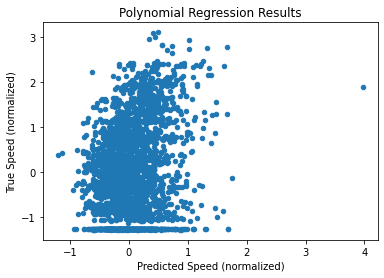

In [ ]:
# Split the data into features (X) and target (y)

X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

"""
# normalize the input (X) and output (y) separately using StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
"""
# create a pipeline that combines normalization and regression
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('regression', LinearRegression())
])

# use KFold cross-validation to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
scores = []
for train_index, val_index in kfold.split(X_train):
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  y_train_fold, y_val = y_train[train_index], y_train[val_index]

  # fit the model to the training data
  model.fit(X_train_fold, y_train_fold)

  # evaluate the model on the validation data
  y_val_pred = model.predict(X_val)
  score = mean_squared_error(y_val, y_val_pred)
  scores.append(score)

# print the average mean squared error across the 5 folds
print("Average MSE:", np.mean(scores))

# evaluate the model on the test data
y_test_pred = model.predict(X_test)
test_score = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_score)

# plot the regression results
plt.scatter(y_test_pred, y_test, s=20)
plt.xlabel("Predicted Speed (normalized)")
plt.ylabel("True Speed (normalized)")
plt.title("Polynomial Regression Results")
plt.show()
